[View in Colaboratory](https://colab.research.google.com/github/etienneRiv/deep-grasp/blob/master/Extraction_Base_de_donn%C3%A9es_et_Entrainement.ipynb)

##Obtention du jeu de données

# Mise en forme de la base de données

Pour pouvoir être exploité, le jeu de données doit d'abord être sur la machine virtuelle Colab. Ce code est là pour ça. Si vous n'utilisez pas votre machine pendant  un certains temps, elle est recyclée: les fichiers téléchargés ne sont pas gardés. IL faut alors tout recompiler.

In [2]:
!pip install --upgrade git+https://github.com/jobevers/diagonal-crop.git
!pip install wget

  Cloning https://github.com/jobevers/diagonal-crop.git to /tmp/pip-ns3yqaz_-build
    100% |████████████████████████████████| 2.0MB 666kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py install for diagonal-crop ... - done
  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /content/.cache/pip/wheels/6d/98/29/61ccc41148f871009126c2e844e26f73eeb25e12cca92228a5
Successfully built wget


### Après avoir exécuté le code précédent, allez dans le menu Exécution / redémarrer l'environnement d'exécution (ou ctrl+M)
#### Il y a un bug avec diagonal-crop, qui risque de ne pas fonctionner correctement sinon. Son installation de Pillow est en conflit avec celle d'origine sur Colab

In [0]:
import numpy as np
from PIL import Image
import diagonal_crop
import matplotlib.pyplot as plt
import os #pour créer des dossiers
import glob #pour manipuler les noms de fichiers
import wget #pour télécharger des fichiers sur internet
import tarfile #pour décompresser des fichiers

Le code suivant permet d'extraire les images des grasps labelisés et les stocker.

In [0]:
def process_graspbox(name):
    """Permet d'extraire les points du fichier de labels"""
    f=open(name, 'r')
    graspbox = list(map(
        lambda coordinate: float(coordinate), f.read().strip().split()))    
    return graspbox

In [0]:
def process_rectangles(graspbox):
    """Rassembler chaque rectangle composé de 4 points"""
    rectangles_grasp=[]
    indices_min=[]
    for i in range(0,len(graspbox)):
        if i%8==0:
            NaN=0
            rect=graspbox[i:i+8]
            points=[]
            ind_mini=0
            mini=rect[0]
            for j in range(0,len(rect),2):
                points.append(rect[j:j+2])
                if rect[j]<mini:
                    mini=rect[j]
                    ind_mini=j
            for k in rect:
                if np.isnan(k)==True:
                    NaN=1
            if NaN==0:
                rectangles_grasp.append(points)
                indices_min.append(ind_mini)
    return rectangles_grasp, indices_min

In [0]:
def rectangle_to_grasp(rectangles_graspbox, index_rectangle,indices_min):
    """Obtenir le grasp sous forme (x_centre, y_centre, theta, hauteur, largeur)"""
    rect=rectangles_graspbox[index_rectangle]
    indice_base=indices_min[index_rectangle]
    height = np.sqrt(np.power(rect[1][0]-rect[0][0],2)+np.power(rect[1][1]-rect[0][1],2))
    width = np.sqrt(np.power(rect[3][0]-rect[0][0],2)+np.power(rect[3][1]-rect[0][1],2))
    x= (rect[2][0]+rect[0][0])/2
    y=(rect[2][1]+rect[0][1])/2
    if (rect[2][0]-rect[1][0]) != 0: #Gestion de la discontinuité de tan.
        tan_theta=(rect[2][1]-rect[1][1])/(rect[2][0]-rect[1][0])
        theta=-np.arctan(tan_theta)
    else:
        theta= np.pi/2
    x_base=rect[indice_base//2][0]
    y_base=rect[indice_base//2][1]
    return x,y,theta,height,width,x_base,y_base

In [0]:
def extraire_rect_specifique(im, x_base,y_base, angle, height, width):
    """Extraction d'un rectangle spécifique dans une image deja ouverte."""
    base=(x_base,y_base)
    rect = diagonal_crop.crop(im, base, angle, height, width)
    return rect

In [0]:
def stockage_rect(rect,classe,rootFolder,im_name,caract_rect):
    """Stocker le rectangle dans des sous-dossiers, que le fonction créé s'ils n'existent pas déjà."""
    x,y,theta,height,width,x_base,y_base=caract_rect
    angle=theta*360/(2*np.pi)
    filename=str(classe)+'_x'+str(int(x_base))+'_y'+str(int(y_base))+'_t'+str(int(angle))+'_h'+str(int(height))+'_w'+str(int(width))+im_name[:-5]+'.png'
    outputFolder=rootFolder
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
    rect.save(outputFolder +'/'+ filename, "PNG")
    return

In [0]:
def save_labeled_rect(imagefilename, dataFolder, saveFolder, classArray):
    """L'ensemble du process pour UNE image. Renvoi le nombre de rectangles de chaque classe 
    et une array avec la liste ordonnée des classes des rectangles de l'image."""
    os.chdir(dataFolder)
    im = Image.open(imagefilename)
    
   
    cpos=imagefilename[:-5]+'cpos.txt'
    rects_pos,indices_pos=process_rectangles(process_graspbox(cpos))
    
    cneg=imagefilename[:-5]+'cneg.txt'
    rects_neg,indices_neg=process_rectangles(process_graspbox(cneg))
    
    i,j=0,0
    
    for i in range(len(rects_pos)):
        caract_rect= rectangle_to_grasp(rects_pos,i,indices_pos)
        x,y,theta,height,width,x_base,y_base=caract_rect
        rect=extraire_rect_specifique(im,x_base,y_base,theta,height,width)
        stockage_rect(rect,1,saveFolder,imagefilename,caract_rect)
        classArray.append(1)
    
    for j in range(len(rects_neg)):
        caract_rect= rectangle_to_grasp(rects_neg,j,indices_neg)
        x,y,theta,height,width,x_base,y_base=caract_rect
        rect=extraire_rect_specifique(im,x_base,y_base,theta,height,width)
        stockage_rect(rect,0,saveFolder,imagefilename,caract_rect)
        classArray.append(0)
        """
    print('File: '+ imagefilename[:-5])
    if i !=0:
        print('Classe 1: '+str(i+1))
    else: 
        print('Classe 1: 0')
    if j!=0:
        print('Classe 0: '+str(j+1))
    else:
        print('Classe0: 0')
        """
    return i,j,classArray

In [0]:
def process_whole_dataset(dataFolder,saveFolder):
    """Parcours l'ensemble du jeu de donnée sauvée dans dataFolder et extrait tous les rectangles labelisés pour
    les stocker sous forme d'images dans une hierarchie de fichier dont le dossier root est saveFolder. Renvoi la liste
    ordonnée des classes des rectangles sous forme d'array."""
    classArray=[]
    directory = os.fsencode(dataFolder)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png"): 
            i,j,classArray = save_labeled_rect(filename,dataFolder,saveFolder,classArray)
            continue
        else:
            continue
    return classArray

### Le code suivant permet de télécharger la base de données directement sur le site de Cornell, et d'extraire les images zippées et d'obtenir les rectangles de grasps

In [9]:
!pip install tqdm #progress bar
from tqdm import tqdm

In [10]:
for i in tqdm(range(1,11)):
  
  if i<10:
    url='http://pr.cs.cornell.edu/grasping/rect_data/temp/data0'+str(i)+'.tar.gz'
    data = wget.download(url)
    Udata= tarfile.open('data0'+str(i)+'.tar.gz','r:gz')
    uncompressed_data=Udata.extractall('/content/CompleteDataset')
    Udata.close()
    listeClasses=process_whole_dataset('/content/CompleteDataset/0'+str(i),'/content/ExtractedDataset')
  
  else:
    url='http://pr.cs.cornell.edu/grasping/rect_data/temp/data10'+'.tar.gz'
    data = wget.download(url)
    Udata= tarfile.open('data10'+'.tar.gz','r:gz')
    uncompressed_data=Udata.extractall('/content/CompleteDataset')
    Udata.close()
    listeClasses=process_whole_dataset('/content/CompleteDataset/10','/content/ExtractedDataset')

print('Done !')

100%|██████████| 10/10 [07:22<00:00, 44.23s/it]

/n Finished !


In [0]:
!du /content/ExtractedDataset #taille du dossier en octets

In [0]:
!ls /content

CompleteDataset    data01.tar.gz  ExtractedDataset
data01.tar (1).gz  datalab	  SeparatedDataset


In [12]:
!ls -1 /content/ExtractedDataset | wc -l #nombre de fichiers dans le jeu de données

16923


In [0]:
!ls /content/ExtractedDataset

Le code suivant permet de créer les répertoires pour séparer, pour chacune des classes POS et NEG, les échantillons de train / validation / test

In [0]:
original_dataset_dir = '/content/ExtractedDataset'
base_dir = '/content/SeparatedDataset'
if not os.path.exists(base_dir):
  os.mkdir(base_dir)
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
  os.mkdir(test_dir)
train_pos_dir = os.path.join(train_dir,'pos')
if not os.path.exists(train_pos_dir):
  os.mkdir(train_pos_dir)
train_neg_dir = os.path.join(train_dir,'neg')
if not os.path.exists(train_neg_dir):
  os.mkdir(train_neg_dir)
validation_pos_dir = os.path.join(validation_dir,'pos')
if not os.path.exists(validation_pos_dir):
  os.mkdir(validation_pos_dir)
validation_neg_dir = os.path.join(validation_dir,'neg')
if not os.path.exists(validation_neg_dir):
  os.mkdir(validation_neg_dir)
test_pos_dir = os.path.join(test_dir,'pos')
if not os.path.exists(test_pos_dir):
  os.mkdir(test_pos_dir)
test_neg_dir = os.path.join(test_dir,'neg')
if not os.path.exists(test_neg_dir):
  os.mkdir(test_neg_dir)

Répartition des rectangles grasps par classe dans les échantillons train / validation / test

In [0]:
import shutil
k=0
for name in glob.glob('/content/ExtractedDataset/0_*'):
  name=name[26:]
  if k<1000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(train_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=1000 and k<1500:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(validation_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=1500 and k<2000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(test_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1

In [0]:
k=0
for name in glob.glob('/content/ExtractedDataset/1_*'):
  name=name[26:]
  if k<1000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(train_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=1000 and k<1500:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(validation_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=1500 and k<2000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(test_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1

In [27]:
print('total training pos images:', len(os.listdir(train_pos_dir)))
print('total validation pos images:', len(os.listdir(validation_pos_dir)))
print('total test pos images:', len(os.listdir(test_pos_dir)))

print('total training neg images:', len(os.listdir(train_neg_dir)))
print('total validation neg images:', len(os.listdir(validation_neg_dir)))
print('total test neg images:', len(os.listdir(test_neg_dir)))


total training pos images: 1000
total validation pos images: 500
total test pos images: 500
total training neg images: 1000
total validation neg images: 500
total test neg images: 500


# Bibliothèques Réseaux

In [3]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


Using TensorFlow backend.


# Réseau CNN de base

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=((50, 50, 3))))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         147584    
__________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
train_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(50,50),
                                                    batch_size=20, 
                                                    class_mode='binary')
validation_generator = train_datagen.flow_from_directory(validation_dir, 
                                                    target_size=(50,50),
                                                    batch_size=20, 
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 50, 50, 3)
labels batch shape: (20,)


In [0]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 5s 45ms/step - loss: 0.6840 - acc: 0.5610 - val_loss: 0.6611 - val_acc: 0.6720
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.6377 - acc: 0.6390 - val_loss: 0.5843 - val_acc: 0.7080
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - loss: 0.5547 - acc: 0.7115 - val_loss: 0.5023 - val_acc: 0.7610
Epoch 4/100
100/100 [==============================] - 3s 28ms/step - loss: 0.5001 - acc: 0.7300 - val_loss: 0.4694 - val_acc: 0.7620
Epoch 5/100
100/100 [==============================] - 3s 27ms/step - loss: 0.4675 - acc: 0.7450 - val_loss: 0.4569 - val_acc: 0.7600
Epoch 6/100
100/100 [==============================] - 3s 25ms/step - loss: 0.4495 - acc: 0.7435 - val_loss: 0.4308 - val_acc: 0.8140
Epoch 7/100
 37/100 [==========>...................] - ETA: 1s - loss: 0.4456 - acc: 0.7716

100/100 [==============================] - 3s 27ms/step - loss: 0.4362 - acc: 0.7765 - val_loss: 0.4495 - val_acc: 0.7520
Epoch 8/100
100/100 [==============================] - 3s 27ms/step - loss: 0.4222 - acc: 0.7745 - val_loss: 0.4391 - val_acc: 0.7640
Epoch 9/100
100/100 [==============================] - 3s 27ms/step - loss: 0.4134 - acc: 0.7850 - val_loss: 0.4182 - val_acc: 0.8090
Epoch 10/100
100/100 [==============================] - 3s 27ms/step - loss: 0.4047 - acc: 0.7860 - val_loss: 0.4526 - val_acc: 0.7460
Epoch 11/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3952 - acc: 0.7970 - val_loss: 0.4250 - val_acc: 0.7710
Epoch 12/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3931 - acc: 0.8030 - val_loss: 0.4166 - val_acc: 0.8030
Epoch 13/100
 52/100 [==============>...............] - ETA: 0s - loss: 0.3824 - acc: 0.8087

100/100 [==============================] - 3s 27ms/step - loss: 0.3848 - acc: 0.8090 - val_loss: 0.4116 - val_acc: 0.8270
Epoch 14/100
100/100 [==============================] - 3s 28ms/step - loss: 0.3792 - acc: 0.8025 - val_loss: 0.4038 - val_acc: 0.8060
Epoch 15/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3674 - acc: 0.8090 - val_loss: 0.4065 - val_acc: 0.8270
Epoch 16/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3656 - acc: 0.8140 - val_loss: 0.4024 - val_acc: 0.8190
Epoch 17/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3592 - acc: 0.8210 - val_loss: 0.4185 - val_acc: 0.8000
Epoch 18/100
100/100 [==============================] - 3s 28ms/step - loss: 0.3542 - acc: 0.8265 - val_loss: 0.4188 - val_acc: 0.8080
Epoch 19/100
 48/100 [=============>................] - ETA: 1s - loss: 0.3395 - acc: 0.8271

100/100 [==============================] - 3s 28ms/step - loss: 0.3478 - acc: 0.8290 - val_loss: 0.4045 - val_acc: 0.8090
Epoch 20/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3461 - acc: 0.8305 - val_loss: 0.4469 - val_acc: 0.7600
Epoch 21/100
100/100 [==============================] - 3s 26ms/step - loss: 0.3391 - acc: 0.8300 - val_loss: 0.3964 - val_acc: 0.8170
Epoch 22/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3306 - acc: 0.8370 - val_loss: 0.4659 - val_acc: 0.7560
Epoch 23/100
100/100 [==============================] - 3s 28ms/step - loss: 0.3288 - acc: 0.8345 - val_loss: 0.4026 - val_acc: 0.8140
Epoch 24/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3257 - acc: 0.8435 - val_loss: 0.3982 - val_acc: 0.8300
Epoch 25/100
 49/100 [=============>................] - ETA: 1s - loss: 0.3145 - acc: 0.8388

100/100 [==============================] - 3s 27ms/step - loss: 0.3206 - acc: 0.8345 - val_loss: 0.4157 - val_acc: 0.7840
Epoch 26/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3156 - acc: 0.8500 - val_loss: 0.4143 - val_acc: 0.8220
Epoch 27/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3057 - acc: 0.8545 - val_loss: 0.3998 - val_acc: 0.8280
Epoch 28/100
100/100 [==============================] - 3s 27ms/step - loss: 0.3012 - acc: 0.8455 - val_loss: 0.4350 - val_acc: 0.7720
Epoch 29/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2931 - acc: 0.8495 - val_loss: 0.4459 - val_acc: 0.8070
Epoch 30/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2880 - acc: 0.8510 - val_loss: 0.4055 - val_acc: 0.8410
Epoch 31/100
 46/100 [============>.................] - ETA: 1s - loss: 0.2869 - acc: 0.8598

100/100 [==============================] - 3s 27ms/step - loss: 0.2833 - acc: 0.8620 - val_loss: 0.4102 - val_acc: 0.8240
Epoch 32/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2878 - acc: 0.8590 - val_loss: 0.4505 - val_acc: 0.7750
Epoch 33/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2772 - acc: 0.8595 - val_loss: 0.4302 - val_acc: 0.7850
Epoch 34/100
100/100 [==============================] - 3s 28ms/step - loss: 0.2699 - acc: 0.8645 - val_loss: 0.4195 - val_acc: 0.8240
Epoch 35/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2652 - acc: 0.8690 - val_loss: 0.4439 - val_acc: 0.7930
Epoch 36/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2606 - acc: 0.8655 - val_loss: 0.4942 - val_acc: 0.8030
Epoch 37/100
 49/100 [=============>................] - ETA: 1s - loss: 0.2742 - acc: 0.8663

100/100 [==============================] - 3s 27ms/step - loss: 0.2555 - acc: 0.8715 - val_loss: 0.4403 - val_acc: 0.8310
Epoch 38/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2525 - acc: 0.8735 - val_loss: 0.4870 - val_acc: 0.8060
Epoch 39/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2467 - acc: 0.8835 - val_loss: 0.4656 - val_acc: 0.8280
Epoch 40/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2380 - acc: 0.8805 - val_loss: 0.4577 - val_acc: 0.8240
Epoch 41/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2339 - acc: 0.8915 - val_loss: 0.6237 - val_acc: 0.7750
Epoch 42/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2371 - acc: 0.8840 - val_loss: 0.4479 - val_acc: 0.7970
Epoch 43/100
 52/100 [==============>...............] - ETA: 0s - loss: 0.2300 - acc: 0.8856

100/100 [==============================] - 3s 27ms/step - loss: 0.2285 - acc: 0.8900 - val_loss: 0.4605 - val_acc: 0.8050
Epoch 44/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2287 - acc: 0.8935 - val_loss: 0.4830 - val_acc: 0.7980
Epoch 45/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2194 - acc: 0.8905 - val_loss: 0.4703 - val_acc: 0.8370
Epoch 46/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2134 - acc: 0.8900 - val_loss: 0.4574 - val_acc: 0.8330
Epoch 47/100
100/100 [==============================] - 3s 28ms/step - loss: 0.2106 - acc: 0.8925 - val_loss: 0.4728 - val_acc: 0.8400
Epoch 48/100
100/100 [==============================] - 3s 28ms/step - loss: 0.2089 - acc: 0.8955 - val_loss: 0.4665 - val_acc: 0.8440
Epoch 49/100
 49/100 [=============>................] - ETA: 1s - loss: 0.2044 - acc: 0.9020

100/100 [==============================] - 3s 27ms/step - loss: 0.2048 - acc: 0.8970 - val_loss: 0.4819 - val_acc: 0.8060
Epoch 50/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2025 - acc: 0.8935 - val_loss: 0.5399 - val_acc: 0.8100
Epoch 51/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1980 - acc: 0.8975 - val_loss: 0.4876 - val_acc: 0.8330
Epoch 52/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1909 - acc: 0.9055 - val_loss: 0.5513 - val_acc: 0.8130
Epoch 53/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1914 - acc: 0.9040 - val_loss: 0.5166 - val_acc: 0.8380
Epoch 54/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1903 - acc: 0.9020 - val_loss: 0.5082 - val_acc: 0.8360
Epoch 55/100
 49/100 [=============>................] - ETA: 1s - loss: 0.1958 - acc: 0.9051

100/100 [==============================] - 3s 27ms/step - loss: 0.1809 - acc: 0.9125 - val_loss: 0.5571 - val_acc: 0.8190
Epoch 56/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1827 - acc: 0.9080 - val_loss: 0.5238 - val_acc: 0.8220
Epoch 57/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1804 - acc: 0.9065 - val_loss: 0.5350 - val_acc: 0.8320
Epoch 58/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1735 - acc: 0.9095 - val_loss: 0.5416 - val_acc: 0.8110
Epoch 59/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1721 - acc: 0.9115 - val_loss: 0.5636 - val_acc: 0.8100
Epoch 60/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1693 - acc: 0.9110 - val_loss: 0.6422 - val_acc: 0.8040
Epoch 61/100
 51/100 [==============>...............] - ETA: 1s - loss: 0.1689 - acc: 0.9137

100/100 [==============================] - 3s 27ms/step - loss: 0.1655 - acc: 0.9145 - val_loss: 0.6566 - val_acc: 0.8020
Epoch 62/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1651 - acc: 0.9130 - val_loss: 0.5595 - val_acc: 0.8370
Epoch 63/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1643 - acc: 0.9165 - val_loss: 0.5911 - val_acc: 0.8240
Epoch 64/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1628 - acc: 0.9205 - val_loss: 0.6298 - val_acc: 0.8200
Epoch 65/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1555 - acc: 0.9135 - val_loss: 0.5929 - val_acc: 0.8320
Epoch 66/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1515 - acc: 0.9195 - val_loss: 0.6122 - val_acc: 0.8270
Epoch 67/100
 49/100 [=============>................] - ETA: 0s - loss: 0.1467 - acc: 0.9245

100/100 [==============================] - 3s 27ms/step - loss: 0.1500 - acc: 0.9240 - val_loss: 0.6542 - val_acc: 0.8220
Epoch 68/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1535 - acc: 0.9210 - val_loss: 0.6306 - val_acc: 0.8390
Epoch 69/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1483 - acc: 0.9165 - val_loss: 0.6370 - val_acc: 0.8130
Epoch 70/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1480 - acc: 0.9225 - val_loss: 0.6902 - val_acc: 0.7970
Epoch 71/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1445 - acc: 0.9305 - val_loss: 0.6623 - val_acc: 0.8060
Epoch 72/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1401 - acc: 0.9320 - val_loss: 0.6877 - val_acc: 0.8290
Epoch 73/100
 49/100 [=============>................] - ETA: 1s - loss: 0.1402 - acc: 0.9204

100/100 [==============================] - 3s 26ms/step - loss: 0.1421 - acc: 0.9190 - val_loss: 0.6972 - val_acc: 0.8180
Epoch 74/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1436 - acc: 0.9295 - val_loss: 0.6582 - val_acc: 0.8340
Epoch 75/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1381 - acc: 0.9255 - val_loss: 0.7557 - val_acc: 0.7960
Epoch 76/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1355 - acc: 0.9270 - val_loss: 0.7318 - val_acc: 0.8090
Epoch 77/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1383 - acc: 0.9290 - val_loss: 0.7805 - val_acc: 0.8140
Epoch 78/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1295 - acc: 0.9305 - val_loss: 0.6852 - val_acc: 0.8330
Epoch 79/100
 46/100 [============>.................] - ETA: 1s - loss: 0.1315 - acc: 0.9293

100/100 [==============================] - 3s 27ms/step - loss: 0.1321 - acc: 0.9305 - val_loss: 0.7267 - val_acc: 0.8330
Epoch 80/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1321 - acc: 0.9295 - val_loss: 0.6955 - val_acc: 0.8320
Epoch 81/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1265 - acc: 0.9285 - val_loss: 0.7381 - val_acc: 0.8330
Epoch 82/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1272 - acc: 0.9285 - val_loss: 0.7465 - val_acc: 0.8450
Epoch 83/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1272 - acc: 0.9330 - val_loss: 0.7571 - val_acc: 0.8330
Epoch 84/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1210 - acc: 0.9345 - val_loss: 0.7456 - val_acc: 0.8300
Epoch 85/100
 48/100 [=============>................] - ETA: 1s - loss: 0.1278 - acc: 0.9281

100/100 [==============================] - 3s 27ms/step - loss: 0.1236 - acc: 0.9315 - val_loss: 0.8079 - val_acc: 0.8110
Epoch 86/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1185 - acc: 0.9375 - val_loss: 0.7619 - val_acc: 0.8330
Epoch 87/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1176 - acc: 0.9360 - val_loss: 0.7664 - val_acc: 0.8300
Epoch 88/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1188 - acc: 0.9425 - val_loss: 0.8176 - val_acc: 0.8060
Epoch 89/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1159 - acc: 0.9400 - val_loss: 0.8124 - val_acc: 0.8210
Epoch 90/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1136 - acc: 0.9365 - val_loss: 0.8307 - val_acc: 0.8120
Epoch 91/100
 49/100 [=============>................] - ETA: 1s - loss: 0.1135 - acc: 0.9388

100/100 [==============================] - 3s 27ms/step - loss: 0.1170 - acc: 0.9330 - val_loss: 0.8559 - val_acc: 0.8110
Epoch 92/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1142 - acc: 0.9335 - val_loss: 0.9591 - val_acc: 0.8190
Epoch 93/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1103 - acc: 0.9405 - val_loss: 0.8606 - val_acc: 0.8270
Epoch 94/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1223 - acc: 0.9380 - val_loss: 0.8386 - val_acc: 0.8290
Epoch 95/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1082 - acc: 0.9360 - val_loss: 0.8417 - val_acc: 0.8280
Epoch 96/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1104 - acc: 0.9395 - val_loss: 0.8854 - val_acc: 0.8230
Epoch 97/100
 48/100 [=============>................] - ETA: 1s - loss: 0.1093 - acc: 0.9406

100/100 [==============================] - 3s 27ms/step - loss: 0.1061 - acc: 0.9420 - val_loss: 0.8466 - val_acc: 0.8280
Epoch 98/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1141 - acc: 0.9350 - val_loss: 0.8736 - val_acc: 0.8290
Epoch 99/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1117 - acc: 0.9395 - val_loss: 0.9363 - val_acc: 0.8000
Epoch 100/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1116 - acc: 0.9380 - val_loss: 0.9167 - val_acc: 0.8200


In [0]:
model.save('grasps_petit_dataset_essai1.h5')

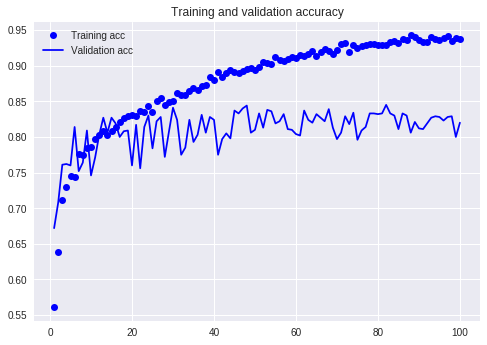

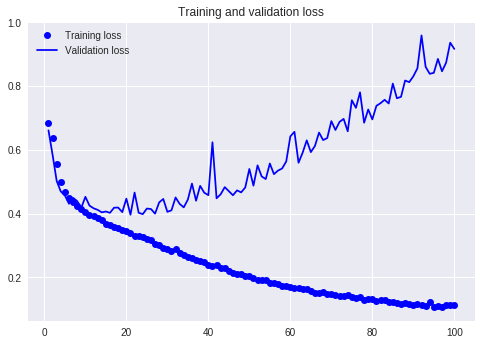

In [0]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Réseau CNN avec Data Augmentation

Pas forcément une très bonne idée finalement, on perd la géométrie des grasps dans certains cas. Peut_être est-il pertinent de réduir le data augmentation à quelques transformations basiques.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

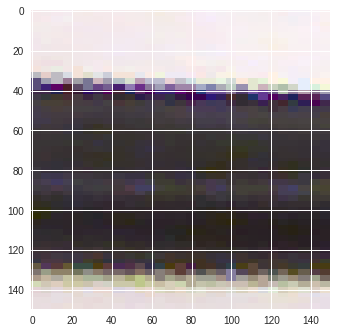

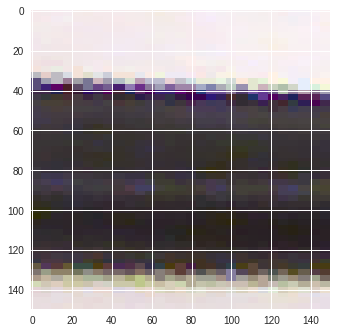

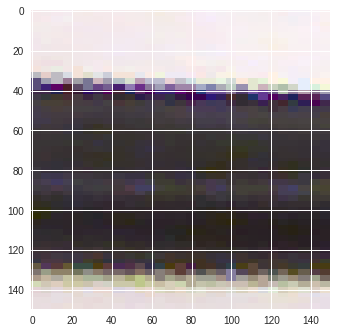

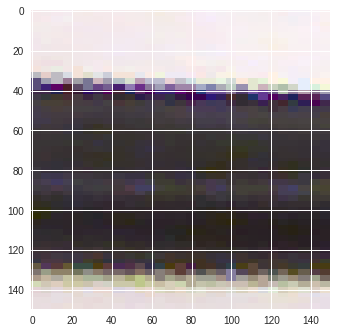

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_pos_dir, fname) for fname in os.listdir(train_pos_dir)]

# We pick one image to "augment"
img_path = fnames[34]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6817 - acc: 0.5492

ValueError: ignored

In [0]:
model.save('grasp_small_sataset_augmented.h5')

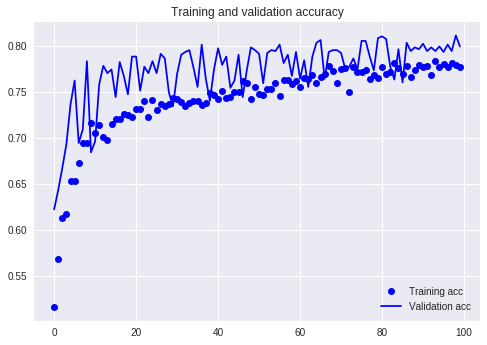

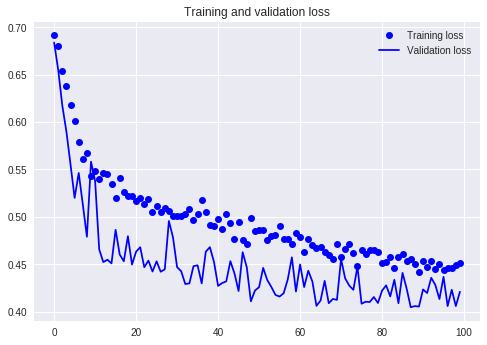

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Ca semble plutot moins bien...

# Réseau Pré-entrainé avec VGG 16 / ImageNet

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(50,50,3))

## Features extraits puis réinjectés

In [87]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 676us/step - loss: 0.5887 - acc: 0.6770 - val_loss: 0.4609 - val_acc: 0.8180
Epoch 2/30
2000/2000 [==============================] - 1s 510us/step - loss: 0.4258 - acc: 0.8025 - val_loss: 0.4014 - val_acc: 0.8030
Epoch 3/30
2000/2000 [==============================] - 1s 548us/step - loss: 0.3843 - acc: 0.8195 - val_loss: 0.3752 - val_acc: 0.8150
Epoch 4/30
2000/2000 [==============================] - 1s 547us/step - loss: 0.3484 - acc: 0.8410 - val_loss: 0.3643 - val_acc: 0.8140
Epoch 5/30
2000/2000 [==============================] - 1s 559us/step - loss: 0.3345 - acc: 0.8375 - val_loss: 0.3584 - val_acc: 0.8170
Epoch 6/30
2000/2000 [==============================] - 1s 548us/step - loss: 0.3282 - acc: 0.8480 - val_loss: 0.3526 - val_acc: 0.8280
Epoch 7/30
2000/2000 [==============================] - 1s 548us/step - loss: 0.3139 - acc: 0.8550 - val_loss: 0.3501 - val_acc: 0.8210


2000/2000 [==============================] - 1s 549us/step - loss: 0.3003 - acc: 0.8565 - val_loss: 0.3510 - val_acc: 0.8390
Epoch 10/30
2000/2000 [==============================] - 1s 555us/step - loss: 0.2935 - acc: 0.8725 - val_loss: 0.3445 - val_acc: 0.8320
Epoch 11/30
2000/2000 [==============================] - 1s 549us/step - loss: 0.2890 - acc: 0.8720 - val_loss: 0.3473 - val_acc: 0.8210
Epoch 12/30
2000/2000 [==============================] - 1s 542us/step - loss: 0.2819 - acc: 0.8715 - val_loss: 0.3427 - val_acc: 0.8450
Epoch 13/30
2000/2000 [==============================] - 1s 548us/step - loss: 0.2791 - acc: 0.8700 - val_loss: 0.3432 - val_acc: 0.8240
Epoch 14/30
2000/2000 [==============================] - 1s 557us/step - loss: 0.2731 - acc: 0.8765 - val_loss: 0.3397 - val_acc: 0.8360
Epoch 15/30
2000/2000 [==============================] - 1s 562us/step - loss: 0.2731 - acc: 0.8720 - val_loss: 0.3438 - val_acc: 0.8250
Epoch 16/30
2000/2000 [==============================

2000/2000 [==============================] - 1s 546us/step - loss: 0.2662 - acc: 0.8860 - val_loss: 0.3432 - val_acc: 0.8270
Epoch 18/30
2000/2000 [==============================] - 1s 542us/step - loss: 0.2661 - acc: 0.8815 - val_loss: 0.3390 - val_acc: 0.8430
Epoch 19/30
2000/2000 [==============================] - 1s 549us/step - loss: 0.2617 - acc: 0.8855 - val_loss: 0.3376 - val_acc: 0.8490
Epoch 20/30
2000/2000 [==============================] - 1s 551us/step - loss: 0.2570 - acc: 0.8910 - val_loss: 0.3388 - val_acc: 0.8480
Epoch 21/30
2000/2000 [==============================] - 1s 542us/step - loss: 0.2565 - acc: 0.8825 - val_loss: 0.3379 - val_acc: 0.8470
Epoch 22/30
2000/2000 [==============================] - 1s 533us/step - loss: 0.2584 - acc: 0.8820 - val_loss: 0.3357 - val_acc: 0.8480
Epoch 23/30
2000/2000 [==============================] - 1s 541us/step - loss: 0.2493 - acc: 0.8835 - val_loss: 0.3405 - val_acc: 0.8310
Epoch 24/30
2000/2000 [==============================

KeyboardInterrupt: ignored

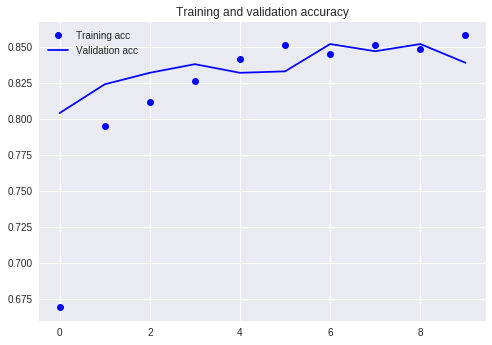

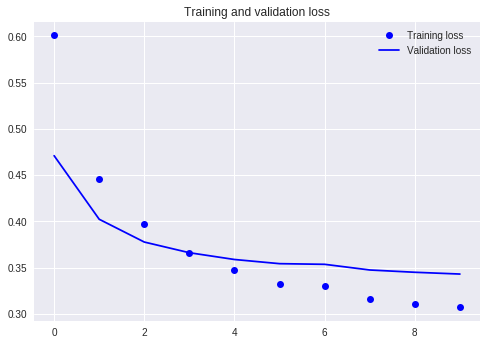

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Réseau dense en bout de VGG 16

Deuixième méthode: réseau dense mis au bout de conv_base. Nous permet d'utiliser le data augmentation

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


In [90]:
print('Nombre de poids entrainables',
       len(model.trainable_weights))
conv_base.trainable = False


print('Nombre de poids entrainables après avoir fixé conv_base '
      , len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [92]:
"""train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')"""
train_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(50, 50),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [93]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
 - 5s - loss: 0.6389 - acc: 0.7125 - val_loss: 0.6057 - val_acc: 0.7780
Epoch 2/10
 - 4s - loss: 0.5676 - acc: 0.8025 - val_loss: 0.5470 - val_acc: 0.8170
Epoch 3/10
 - 4s - loss: 0.5141 - acc: 0.8225 - val_loss: 0.5024 - val_acc: 0.8340
Epoch 4/10
 - 4s - loss: 0.4733 - acc: 0.8390 - val_loss: 0.4661 - val_acc: 0.8370
Epoch 5/10
 - 4s - loss: 0.4413 - acc: 0.8515 - val_loss: 0.4384 - val_acc: 0.8530
Epoch 6/10
 - 4s - loss: 0.4179 - acc: 0.8595 - val_loss: 0.4167 - val_acc: 0.8480
Epoch 7/10
 - 5s - loss: 0.3983 - acc: 0.8625 - val_loss: 0.3980 - val_acc: 0.8560
Epoch 8/10
 - 4s - loss: 0.3823 - acc: 0.8635 - val_loss: 0.3829 - val_acc: 0.8580
Epoch 9/10
 - 4s - loss: 0.3704 - acc: 0.8640 - val_loss: 0.3717 - val_acc: 0.8600
Epoch 10/10
 - 4s - loss: 0.3609 - acc: 0.8650 - val_loss: 0.3628 - val_acc: 0.8590


In [0]:
model.save('grasping_vgg16_50.h5')

In [0]:
print(os.getcwd())
!ls

Importer un modèle enregistrer déjà sauvé.

In [0]:
from keras.models import load_model
model=load_model('grasping_vgg16_1.h5')

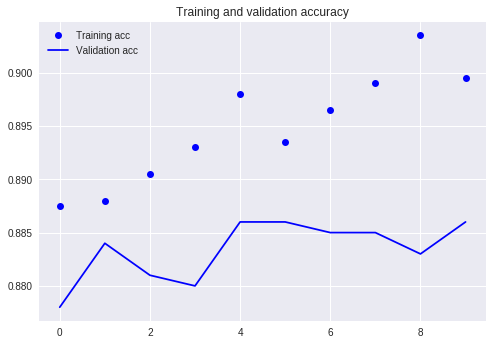

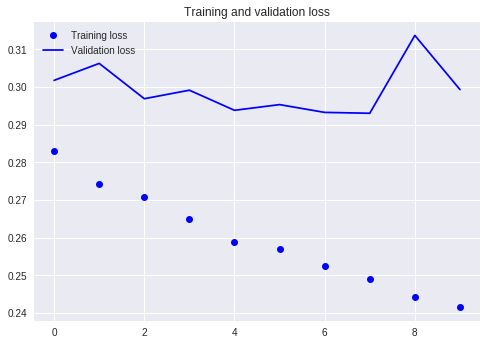

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Predictions et utilisation du réseau

Importer une image à tester. Dans certains cas, soulève une erreur sur firefox. Dans ce ca-là, utilisez chrome.

In [55]:
os.chdir('/content')
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pcd0118r.png to pcd0118r.png
User uploaded file "pcd0118r.png" with length 398027 bytes


## Essais non aboutis
Bouts de codes qui n'ont pas vraiment servi pour linstant.

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        testdir,
        target_size=(150, 150),
        batch_size=20,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

probabilities = model.predict_generator(test_generator, 100)

Found 0 images belonging to 0 classes.


KeyboardInterrupt: ignored

In [0]:
print(probabilities)

[[3.6565635e-02]
 [1.6909547e-01]
 [3.1095513e-07]
 ...
 [9.8992682e-01]
 [9.9954778e-01]
 [9.9999976e-01]]


In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
% matplotlib inline


y_true = np.array([0] * 1000 + [1] * 1000)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred)

array([[586, 414],
       [586, 414]])

In [0]:
!ls

11 (1).jpg  CompleteDataset  datalab	       SeparatedDataset
11.jpg	    data01.tar.gz    ExtractedDataset


In [57]:
img=Image.open('/content/pcd0134r.png')
img_array= np.asarray(img)[:,:,:3]
img_array=img_array/255
print(img_array.shape)

print(img_array)

[[[ 90  84  79]
  [ 90  82  77]
  [ 91  81  82]
  ...
  [ 10   7   8]
  [ 13   6   8]
  [ 17   5   8]]

 [[ 89  82  79]
  [ 89  81  77]
  [ 90  80  76]
  ...
  [ 11   6   8]
  [ 10   6   8]
  [ 10   5   8]]

 [[ 89  82  82]
  [ 89  81  78]
  [ 89  79  74]
  ...
  [ 12   8   7]
  [  8   9   9]
  [  4   9   9]]

 ...

 [[216 204 202]
  [216 202 203]
  [218 204 204]
  ...
  [ 75  54  62]
  [ 76  56  76]
  [ 77  60  76]]

 [[216 203 198]
  [216 204 201]
  [219 206 203]
  ...
  [ 71  50  52]
  [ 74  52  66]
  [ 77  55  66]]

 [[216 204 198]
  [216 205 200]
  [219 205 203]
  ...
  [ 71  50  42]
  [ 74  52  57]
  [ 77  54  57]]]
(480, 640, 3)
[[[0.35294118 0.32941176 0.30980392]
  [0.35294118 0.32156863 0.30196078]
  [0.35686275 0.31764706 0.32156863]
  ...
  [0.03921569 0.02745098 0.03137255]
  [0.05098039 0.02352941 0.03137255]
  [0.06666667 0.01960784 0.03137255]]

 [[0.34901961 0.32156863 0.30980392]
  [0.34901961 0.31764706 0.30196078]
  [0.35294118 0.31372549 0.29803922]
  ...
  [0.0431

In [0]:
import tensorflow as tf

In [0]:
image11=tf.extract_image_patches(
    x,
    [1,150,150,3],
    [1,50,50,1],
    [1,0,0,0],
    "SAME",
    name=None
)

In [0]:
print(image11[0][0][0])

Tensor("strided_slice_4:0", shape=(67500,), dtype=float32)


67500=150x150x3

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

array = image11.eval(sess)
print (array) 

prediction=model.predict(array)
  
 

In [0]:
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Prédictions 
la fenêtre flottante parcours uniquement l'image avec un carré droit (pas d'angles)

In [56]:
img = image.load_img('/content/11.jpg')

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

AttributeError: ignored

In [96]:
from sklearn.feature_extraction import image
import numpy as np

#patches_img=image.extract_patches(img_array,patch_shape=(150,150,3),extraction_step=50)
patches_img=image.extract_patches_2d(img_array, (50,50), max_patches=0.01, random_state=None)
print(patches_img.shape)


(2547, 50, 50, 3)


In [97]:
first_patch=patches_img[:]
#first_patch = first_patch.reshape((1,) + first_patch.shape)
print(first_patch.shape)

(2547, 50, 50, 3)


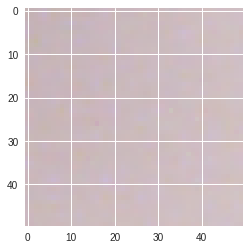

In [102]:
%matplotlib inline
from matplotlib.pyplot import imshow

imshow(first_patch[-2])

#Image.fromarray(first_patch[0]).show()

In [127]:
prediction_first_patch= model.predict(first_patch[2500:])
print(prediction_first_patch)

[[0.7219579 ]
 [0.73501176]
 [0.7348712 ]
 [0.7281397 ]
 [0.69764304]
 [0.6401901 ]
 [0.7260018 ]
 [0.83631563]
 [0.61108935]
 [0.71289325]
 [0.72718835]
 [0.7326315 ]
 [0.23982997]
 [0.34509942]
 [0.5211765 ]
 [0.61487985]
 [0.718404  ]
 [0.7292827 ]
 [0.7359817 ]
 [0.7255319 ]
 [0.26067585]
 [0.8219658 ]
 [0.37292123]
 [0.49788764]
 [0.7084431 ]
 [0.7403539 ]
 [0.6748198 ]
 [0.741248  ]
 [0.7360305 ]
 [0.7314741 ]
 [0.7332777 ]
 [0.7351724 ]
 [0.73497665]
 [0.7246853 ]
 [0.4109345 ]
 [0.696095  ]
 [0.21931602]
 [0.365046  ]
 [0.69893503]
 [0.70005476]
 [0.6958172 ]
 [0.73186564]
 [0.45261148]
 [0.11146834]
 [0.7104758 ]
 [0.7061971 ]
 [0.81815994]]


[0.21931602]


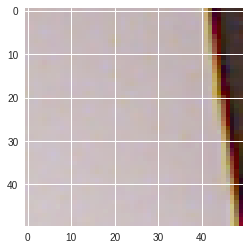

In [130]:
nb=-11
print(prediction_first_patch[nb])
imshow(first_patch[nb])

In [0]:
img2=Image.open('/content/7.jpg')
img_array2= np.asarray(img2)[:,:,:3]
img_array2=img_array2/255
print(img_array2.shape)
patches_img2=image.extract_patches_2d(img_array2, (150,150), max_patches=0.1, random_state=None)
print(patches_img2.shape)


(225, 225, 3)
(577, 150, 150, 3)


(1, 150, 150, 3)


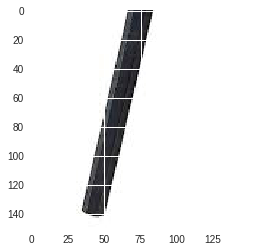

In [0]:
first_patch2=patches_img2[500]
first_patch2 = first_patch2.reshape((1,) + first_patch2.shape)
print(first_patch2.shape)
imshow(first_patch2[0])

In [0]:
prediction_first_patch2= model.predict(first_patch2)
print(prediction_first_patch2)

[[2.796018e-05]]


(1, 150, 150, 3)


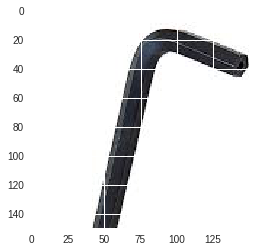

In [0]:
first_patch3=patches_img2[4]
first_patch3 = first_patch3.reshape((1,) + first_patch3.shape)
print(first_patch3.shape)
imshow(first_patch3[0])

In [0]:
prediction_first_patch3= model.predict(first_patch3)
print(prediction_first_patch3)

[[5.9776437e-05]]


# Imprter / Sauver des fichiers depuis Google Drive

Pour ne pas réexecuter l'ensemble du code à chaque fois, on peut sauver le modèle sur un drive google, et simplement le réuploader quand il faut.
On considère avec le programme suivant le drive comme un dossier dans la machine virtuelle.

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive

In [0]:
!cp grasping_vgg16_50.h5 /content/drive